In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.ticker as ticker

# pd.options.display.max_columns = 50
# pd.options.display.max_rows = 200

In [2]:
boston = pd.read_csv('boston_listings.csv', index_col='id')

In [3]:
print(boston.shape)

(3845, 105)


In [4]:
# After some exploratory analysis, I selected the followig features to build model to predict price
features = ['neighbourhood_cleansed', 'property_type', 'accommodates', 'bedrooms', 'bathrooms','number_of_reviews', 'review_scores_rating', 'instant_bookable',
            'has_availability','is_business_travel_ready', 'require_guest_phone_verification', 'security_deposit', 'cleaning_fee', 'calculated_host_listings_count'
           ]

In [5]:
# for the columns that have binary value of "t" and "f", encode the value to numeric value of 1 and 0 
def encode_t_f(val):
    """
    Encode string t/f to 1/0, "t"->1, "f"->0
    Args:
        val: string, t/f
    Returns:
        number: int, 1/0
    """
    return 1 if val == "t" else 0

In [6]:
def preprocess_data(df):
    """
    Preprocessing the selected input features and return the processed input feature X and label y
    Args:
        df: DataFrame, boston or seattle dataframe
    Returns:
        X: preprocessed input features
        y: the price that model will predict
    """
    # remove the listings whose property type counts less than 1% of te total properties
    property_type_counts = df['property_type'].value_counts() 
    select_property_types =  property_type_counts[property_type_counts / df.shape[0] > .01].index
    df = df[df['property_type'].isin(select_property_types)].copy()
    
    # change price from string to number for target label
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    # remove the listings where prices less than or equal to 0 and greater than 500, which are likely to be mistake
    df = df[(df['price'] > 0) & (df['price'] < 500)]
    # remove the first time list as the first time list may not be priced properly
    df = df[df['calculated_host_listings_count'] > 1]
    # remove the neghbourhood where is has less than 10 listings
    neighbourhood_listings = df['neighbourhood_cleansed'].value_counts()
    neighbourhood_listings_too_few = neighbourhood_listings[neighbourhood_listings < 10].index
    df = df[~df['neighbourhood_cleansed'].isin(neighbourhood_listings_too_few)]
    # remove rows where neighbourhood or property_type is NaN, there is only one row with missing data in Seattle dataset
    # df.dropna(subset=['neighbourhood_cleansed', 'property_type'], inplace=True)
    
    X = df[features].copy()
    y = df['price']
    X.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
    
    # convert security_deposit from string to number and fill nan with 0
    X.security_deposit = X.security_deposit.replace('[\$,]', '', regex=True).astype(float).fillna(0)
    X.cleaning_fee = X.cleaning_fee.replace('[\$,]', '', regex=True).astype(float).fillna(0)
    
    # encode the following columns
    columns_to_encode = [
        'instant_bookable', 'has_availability','is_business_travel_ready', 'require_guest_phone_verification']
    for col in columns_to_encode:
        X[col] = X[col].apply(encode_t_f)
    
    # impute the rest numeric features using average value
    impute_cols = X.columns[X.count() < X.shape[0]]
    imputer = SimpleImputer(strategy='median')
    X[impute_cols] = imputer.fit_transform(X[impute_cols])
    
    # one-hot encode the categorical features
    X = pd.get_dummies(X)

    return X, y   

In [7]:
def display_metrics(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Model Score:', model.score(X_test, y_test))

In [8]:
# Build price prediction model for boston
X, y = preprocess_data(boston)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
display_metrics(y_test, y_pred)
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Mean Absolute Error: 43.46415770609319
Mean Squared Error: 3482.8512544802866
Model Score: 0.5917951274621569


In [9]:
actual_vs_predicted.sample(25, random_state=1)

,Actual,Predicted
id,,
6759004,150.0,162.0
23429071,42.0,102.0
35915047,120.0,214.0
26214081,220.0,198.0
39632515,139.0,138.0
32864453,199.0,218.0
25382895,159.0,158.0
23327474,247.0,180.0
19540224,200.0,236.0


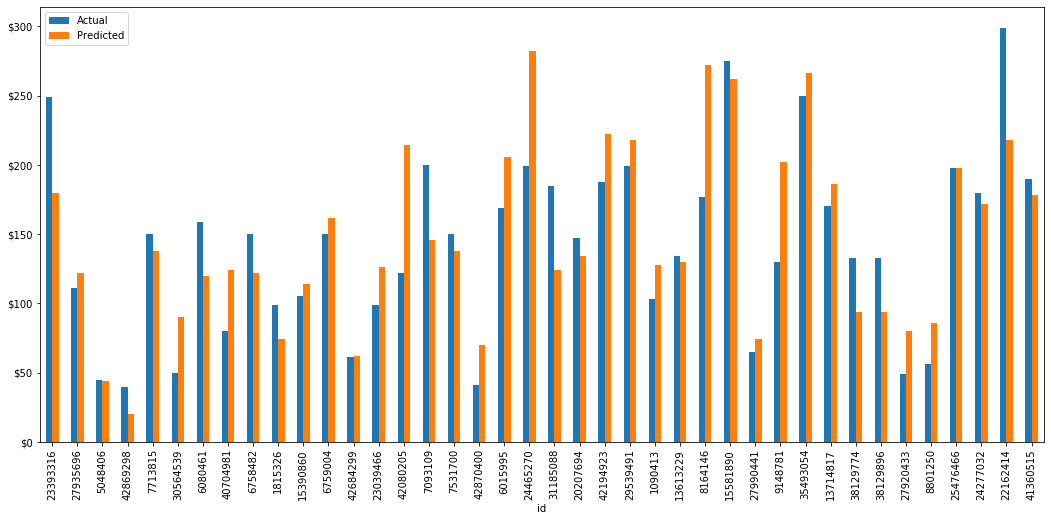

In [10]:
ax=actual_vs_predicted.sample(40, random_state=0).plot.bar(figsize=(18, 8))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%1.0f'))